<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B4%5D_ODE_Supervised_and_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits : Mahmoud Asem @Asem000  Septemeber 2021

Problem motivation credits : [Chris Rackauckas](https://chrisrackauckas.com) from [MIT 18.837](https://mitmath.github.io/18337/lecture3/sciml.html)


### Supervised learning with PINN

the aim of this notebook is to demonstrated how can we use assumed/approximated physics loss along with supervised loss to better predict an arbitrary model given limited  measurements.

We measure the force at locations x_i of of a **real** spring system and use the x_i->F(x_i) pairs for supervised training . We later **assume** that the real spring follows hookes law and encode the **ideal** spring law in the physics loss formulation with the superivised loss .

We compare the real spring (x,F(x)) against both strictly supervised loss and supervised loss with ideal spring physics loss

<img src="https://i.imgur.com/A2fwUNg.png" width=50%>

<img src="https://i.imgur.com/wwpNTTi.png" width=50%>

In [1]:
#Imports
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
!pip install numba
import numba
import sympy as sp

### Mass-Spring-Damper Problem

We construct the following mass spring damper problem . Then we select about 7 points as our measurements points .


In [2]:
t,k,m,c= sp.symbols('t k  m c')
x = sp.Function('x')

diffeq = sp.Eq(m*x(t).diff(t,t) +k*x(t) + c* x(t).diff(t) ,0)
diffeq

Eq(c*Derivative(x(t), t) + k*x(t) + m*Derivative(x(t), (t, 2)), 0)

$\text{State space representation}$

$\frac{d}{dt}$
$\begin{bmatrix}
x  \\
\dot{x} 
\end{bmatrix}$
$=$
$
\begin{bmatrix}
0 & 1  \\
\frac{-k}{m} & \frac{-c}{m} 
\end{bmatrix}
$
$\begin{bmatrix}
x  \\
\dot{x} 
\end{bmatrix}$

$\frac{dx}{dt}=\dot{x}$

$\frac{d^2x}{dt^2} =\frac{-k}{m} \ x +\frac{-c}{m} \ \dot{x}$ 


#### Problem configuration

In [3]:
kv = 1  #spring constant
mv = 1  # mass
cv = 0.5 # damping coefficient
diffeq = diffeq.subs({k:kv,c:cv,m:mv})
diffeq

Eq(x(t) + 0.5*Derivative(x(t), t) + Derivative(x(t), (t, 2)), 0)

In [4]:
# inital conditon
sp.Eq(x(t).subs(t,0),0)

Eq(x(0), 0)

In [5]:
# inital condition
sp.Eq(x(t).diff(t).subs(t,0),1)

Eq(Subs(Derivative(x(t), t), t, 0), 1)

In [6]:
ics={
    x(0):0,
    x(t).diff(t).subs(t,0):1,   
     }

In [7]:
#Displacement
D = sp.simplify(sp.dsolve(diffeq,ics=ics).rhs) 

#Velocity
V = D.diff(t)

#Force
F = -kv * D - cv* D.diff(t) 

Text(0.5, 1.0, 'Force measurements')

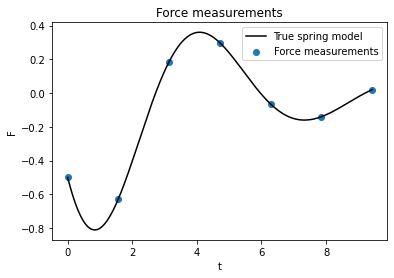

In [8]:
D_func = sp.lambdify(t,D)
V_func = sp.lambdify(t,V)
F_func = sp.lambdify(t,F)

# Full solution
dT = 1e-3
T_full = np.arange(0,3*np.pi+dT,dT)
D_full = D_func(T_full)
V_full = V_func(T_full)
F_full = F_func(T_full)

# Measurement solution 
dT = np.pi/2
T_part = np.arange(0,3*np.pi+dT,dT)
D_part = D_func(T_part)
V_part = V_func(T_part)
F_part = F_func(T_part)

plt.figure(1);
plt.plot(T_full,F_full,'k',label='True spring model');
plt.scatter(T_part,F_part,label='Force measurements');

plt.legend();
plt.xlabel('t');
plt.ylabel('F')
plt.title('Force measurements')


In [10]:
# time position
X = T_part.reshape(-1,1)

# force position
Y = F_part.reshape(-1,1)

conds = jnp.concatenate([X,Y],axis=1)

#collocation points
colloc = jnp.linspace(0,3*np.pi,1_000).reshape(-1,1)

### Constructing the MLP

In [12]:
def ODE_loss(t,x):
  x_t=lambda t:jax.grad(lambda t:jnp.sum(x(t)))(t)
  x_tt=lambda t:jax.grad(lambda t:jnp.sum(x_t(t)))(t)
  return x_tt(t) + 1.0*x(t)

In [13]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds,Alpha=1.0,Beta= 0.0):
  '''
  Conds => Function satisfied at measured points by supervised loss and physics loss
  colloc=> Function satisfied at the collocation points by physics loss
  '''
  X,Y = conds[:,[0]],conds[:,[1]]
  t_c = colloc #collocation point
  loss = 0.

  supervised_loss = Alpha * jnp.mean((fwd(params,X) - Y)**2)
  loss += supervised_loss
  
  xfunc = lambda t : fwd(params,t)
  physics_loss = Beta * jnp.mean(ODE_loss(t_c,xfunc)**2)
  loss += physics_loss
  
  return loss

@jax.jit
def update(opt_state,params,colloc,conds,Alpha=1.0,Beta=0.0):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds,Alpha,Beta)
  
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params



### Supervised only


We try to map the x->F(x) with strictly supervised loss formulation

In [14]:
%%time

Alpha,Beta = 1.,0.

# construct the MLP of  6 hidden layers of 8 neurons for each layer
params = init_params([1] + [8]*6+[1])

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds,Alpha,Beta)

  # print loss and epoch info
  if _ %(1000) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds,Alpha,Beta):.3e}')

Epoch=0	loss=1.408e+00
Epoch=1000	loss=3.678e-03
Epoch=2000	loss=2.715e-10
Epoch=3000	loss=3.515e-10
Epoch=4000	loss=6.840e-10
Epoch=5000	loss=4.076e-12
Epoch=6000	loss=2.777e-11
Epoch=7000	loss=1.161e-05
Epoch=8000	loss=3.482e-06
Epoch=9000	loss=1.643e-05
CPU times: user 31.2 s, sys: 482 ms, total: 31.7 s
Wall time: 31.7 s


Text(0.5, 1.0, 'Supervised training only')

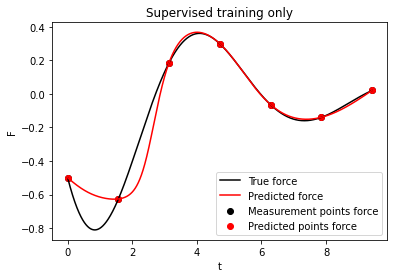

In [15]:
pred = fwd(params,X)

plt.figure(3);

plt.plot(T_full,F_full,'k',label='True force');
plt.scatter(T_part,F_part,c='k',label='Measurement points force');

plt.plot(T_full.reshape(-1,1),fwd(params,T_full.reshape(-1,1)),'r',label='Predicted force')
plt.scatter(T_part.reshape(-1,1),fwd(params,T_part.reshape(-1,1)),c='r',label='Predicted points force')

plt.legend();
plt.xlabel('t');
plt.ylabel('F')
plt.title('Supervised training only')


### Physics loss with Supervised loss

In here , **we use hookes law approximation** for the physics loss as we observe that the model at hand is ideally a spring

$Loss \ function = \alpha . SupervisedLoss + \beta .PhysicsLoss$

$ \alpha = 1 \ , \ \beta = 0.1$

In [16]:
%%time

Alpha,Beta = 1.,0.1

# construct the MLP of  6 hidden layers of 8 neurons for each layer
params = init_params([1] + [8]*6+[1])

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds,Alpha,Beta)

  # print loss and epoch info
  if _ %(1000) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds,Alpha,Beta):.3e}')

Epoch=0	loss=1.514e+00
Epoch=1000	loss=1.100e-02
Epoch=2000	loss=1.454e-03
Epoch=3000	loss=1.432e-03
Epoch=4000	loss=1.420e-03
Epoch=5000	loss=1.412e-03
Epoch=6000	loss=1.409e-03
Epoch=7000	loss=1.406e-03
Epoch=8000	loss=1.418e-03
Epoch=9000	loss=1.403e-03
CPU times: user 20.3 s, sys: 374 ms, total: 20.7 s
Wall time: 20.7 s


Text(0.5, 1.0, 'Supervised loss + PINN loss training')

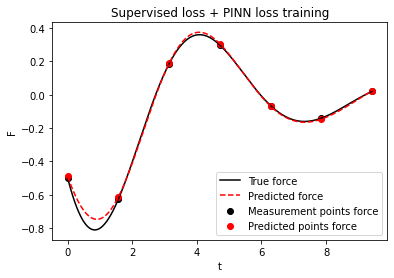

In [17]:
pred = fwd(params,X)

plt.figure(3);

plt.plot(T_full,F_full,'k',label='True force');
plt.scatter(T_part,F_part,c='k',label='Measurement points force');

plt.plot(T_full.reshape(-1,1),fwd(params,T_full.reshape(-1,1)),'--r',label='Predicted force')
plt.scatter(T_part.reshape(-1,1),fwd(params,T_part.reshape(-1,1)),c='r',label='Predicted points force')

plt.legend();
plt.xlabel('t');
plt.ylabel('F')
plt.title('Supervised loss + PINN loss training')
